#### Book Recommender System ###
This notebook uses the [goodbooks-10K dataset](https://github.com/zygmuntz/goodbooks-10k) to build a similarity based recommendation system.
Given a book as input, it suggests 8 similiar books based on:  
a) Content based filtering - books with similiar genres  
b) Collaborative filtering - books other users liked  

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
import pickle
from sklearn.preprocessing import MinMaxScaler

#### Exploratory Data Analysis ####

In [51]:
rating = pd.read_csv('../data/raw/goodreads/ratings.csv')
books = pd.read_csv('../data/raw/goodreads/books.csv')
tags = pd.read_csv('../data/raw/goodreads/tags.csv')
book_tags = pd.read_csv('../data/raw/goodreads/book_tags.csv')

In [317]:
# close to 6 million ratings with avg rating of 3.9 and most books seem to be highly rated
print(rating.head())
rating.describe()

   user_id  book_id  rating
0        1      258       5
1        2     4081       4
2        2      260       5
3        2     9296       5
4        2     2318       3


,user_id,book_id,rating
count,5.976479e+06,5.976479e+06,5.976479e+06
mean,2.622446e+04,2.006477e+03,3.919866e+00
std,1.541323e+04,2.468499e+03,9.910868e-01
min,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.281300e+04,1.980000e+02,3.000000e+00
50%,2.593800e+04,8.850000e+02,4.000000e+00
75%,3.950900e+04,2.973000e+03,5.000000e+00
max,5.342400e+04,1.000000e+04,5.000000e+00


In [318]:
tags.head()

   tag_id tag_name
0       0        -
1       1     --1-
2       2    --10-
3       3    --12-
4       4   --122-


,tag_id
count,34252.000000
mean,17125.500000
std,9887.845047
min,0.000000
25%,8562.750000
50%,17125.500000
75%,25688.250000
max,34251.000000


In [238]:
print(book_tags.head())
book_tags.describe()

   goodreads_book_id  tag_id   count
0                  1   30574  167697
1                  1   11305   37174
2                  1   11557   34173
3                  1    8717   12986
4                  1   33114   12716


,goodreads_book_id,tag_id,count
count,9.999120e+05,999912.000000,999912.000000
mean,5.263442e+06,16324.527073,208.869633
std,7.574057e+06,9647.846196,3501.265173
min,1.000000e+00,0.000000,-1.000000
25%,4.622700e+04,8067.000000,7.000000
50%,3.948410e+05,15808.000000,15.000000
75%,9.378297e+06,24997.000000,40.000000
max,3.328864e+07,34251.000000,596234.000000


In [22]:
# most popular tags
t = book_tags.groupby('tag_id').agg({'count':['sum']})
t.columns = ['count']
pop_tags = tags.merge(t, on='tag_id')
pop_tags.sort_values(by='count', ascending=False).head(25)

,tag_id,tag_name,count
30574,30574,to-read,140718761
8717,8717,currently-reading,7507958
11557,11557,favorites,4503173
11743,11743,fiction,3688819
11305,11305,fantasy,3548157
33114,33114,young-adult,1848306
7457,7457,classics,1756920
5207,5207,books-i-own,1317235
26138,26138,romance,1231926
22743,22743,owned,1224279


In [61]:
# 10k books with an avg rating of 4 and an avergae of 51k and median of 21k ratings per book
print(books.columns.values)
books.describe()

['book_id' 'goodreads_book_id' 'best_book_id' 'work_id' 'books_count'
 'isbn' 'isbn13' 'authors' 'original_publication_year' 'original_title'
 'title' 'language_code' 'average_rating' 'ratings_count'
 'work_ratings_count' 'work_text_reviews_count' 'ratings_1' 'ratings_2'
 'ratings_3' 'ratings_4' 'ratings_5' 'image_url' 'small_image_url']


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn13,original_publication_year,average_rating,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5
count,10000.00000,1.000000e+04,1.000000e+04,1.000000e+04,10000.000000,9.415000e+03,9979.000000,10000.000000,1.000000e+04,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,1.000000e+04
mean,5000.50000,5.264697e+06,5.471214e+06,8.646183e+06,75.712700,9.755044e+12,1981.987674,4.002191,5.400124e+04,5.968732e+04,2919.955300,1345.040600,3110.885000,11475.893800,1.996570e+04,2.378981e+04
std,2886.89568,7.575462e+06,7.827330e+06,1.175106e+07,170.470728,4.428619e+11,152.576665,0.254427,1.573700e+05,1.678038e+05,6124.378132,6635.626263,9717.123578,28546.449183,5.144736e+04,7.976889e+04
min,1.00000,1.000000e+00,1.000000e+00,8.700000e+01,1.000000,1.951703e+08,-1750.000000,2.470000,2.716000e+03,5.510000e+03,3.000000,11.000000,30.000000,323.000000,7.500000e+02,7.540000e+02
25%,2500.75000,4.627575e+04,4.791175e+04,1.008841e+06,23.000000,9.780316e+12,1990.000000,3.850000,1.356875e+04,1.543875e+04,694.000000,196.000000,656.000000,3112.000000,5.405750e+03,5.334000e+03
50%,5000.50000,3.949655e+05,4.251235e+05,2.719524e+06,40.000000,9.780452e+12,2004.000000,4.020000,2.115550e+04,2.383250e+04,1402.000000,391.000000,1163.000000,4894.000000,8.269500e+03,8.836000e+03
75%,7500.25000,9.382225e+06,9.636112e+06,1.451775e+07,67.000000,9.780831e+12,2011.000000,4.180000,4.105350e+04,4.591500e+04,2744.250000,885.000000,2353.250000,9287.000000,1.602350e+04,1.730450e+04
max,10000.00000,3.328864e+07,3.553423e+07,5.639960e+07,3455.000000,9.790008e+12,2017.000000,4.820000,4.780653e+06,4.942365e+06,155254.000000,456191.000000,436802.000000,793319.000000,1.481305e+06,3.011543e+06


In [62]:
# most popular books
books['original_title'].head(15)

0                                      The Hunger Games
1              Harry Potter and the Philosopher's Stone
2                                              Twilight
3                                 To Kill a Mockingbird
4                                      The Great Gatsby
5                                The Fault in Our Stars
6                    The Hobbit or There and Back Again
7                                The Catcher in the Rye
8                                      Angels & Demons 
9                                   Pride and Prejudice
10                                     The Kite Runner 
11                                            Divergent
12                                 Nineteen Eighty-Four
13                           Animal Farm: A Fairy Story
14    Het Achterhuis: Dagboekbrieven 14 juni 1942 - ...
Name: original_title, dtype: object

In [348]:
# number of ratings per user and average user rating
user_ratings = rating.groupby('user_id').agg({'rating':['count', 'mean']})
# users have rated 111 books on average
# flatten the multi index df
user_ratings.columns = ['total_ratings', 'avg_ratings']
print(user_ratings.describe())

       total_ratings   avg_ratings
count   53424.000000  53424.000000
mean      111.868804      3.928512
std        26.071224      0.449543
min        19.000000      1.000000
25%        96.000000      3.633929
50%       111.000000      3.920455
75%       128.000000      4.223214
max       200.000000      5.000000


[Text(209.61818181818177, 0.5, 'avg_ratings'),
 Text(0.5, 15.0, 'Mean user rating')]

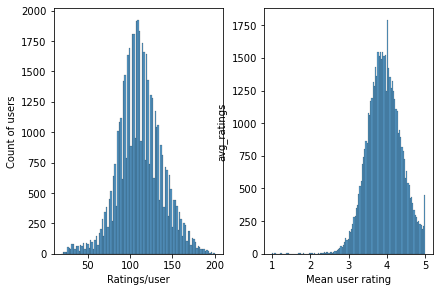

In [351]:
# plot mean rating and number of ratings per user
fig, axes = plt.subplots(1,2) 
fig.tight_layout()
ax1 = sns.histplot(data=user_ratings, x='total_ratings', ax= axes[0])
ax1.set(xlabel="Ratings/user", ylabel="Count of users")
# there is a large divergence and one user has rated 11,000 books while the mean rating is 11
ax2 = sns.histplot(data=user_ratings, x='avg_ratings', ax=axes[1])
ax2.set(xlabel="Mean user rating", ylabel="avg_ratings")
# number of user rating = 0 is high due to high number of implicit ratings and avg rating is 4.39

In [353]:
# find total number of ratings and average rating for each book
book_ratings = rating.groupby('book_id').agg({'rating':['count', 'mean']})
# On avergae each book ahs been rated 597 times and the min rated book has 8 ratings
book_ratings.columns = ['total_ratings', 'avg_ratings']
book_ratings.describe()

,total_ratings,avg_ratings
count,10000.000000,10000.000000
mean,597.647900,3.903136
std,1267.289788,0.285346
min,8.000000,2.077966
25%,155.000000,3.728160
50%,248.000000,3.922021
75%,503.000000,4.097793
max,22806.000000,4.829876


[Text(209.61818181818177, 0.5, 'Count of books'),
 Text(0.5, 15.0, 'Mean book rating')]

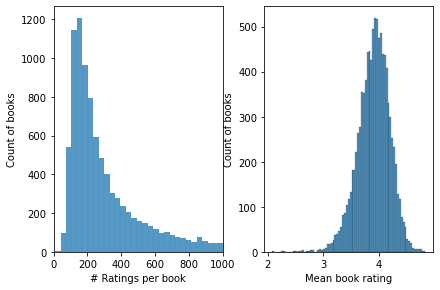

In [355]:
# plot mean rating and number of ratings per book
fig, axes = plt.subplots(1,2) 
fig.tight_layout()
ax1 = sns.histplot(data=book_ratings, x='total_ratings', ax= axes[0])
ax1.set(xlabel="# Ratings per book", ylabel="Count of books")
ax1.set(xlim=(0,1000))
# there is a large divergence and one user has rated 11,000 books while the mean rating is 11
ax2 = sns.histplot(data=book_ratings, x='avg_ratings', ax=axes[1])
ax2.set(xlabel="Mean book rating", ylabel="Count of books")

#### Data Cleaning and Getting Features ####

In [63]:
# available languages
books['language_code'].unique()

array(['eng', 'en-US', 'en-CA', nan, 'spa', 'en-GB', 'fre', 'nl', 'ara',
       'por', 'ger', 'nor', 'jpn', 'en', 'vie', 'ind', 'pol', 'tur',
       'dan', 'fil', 'ita', 'per', 'swe', 'rum', 'mul', 'rus'],
      dtype=object)

In [52]:
# pick only english books
books = books.loc[books['language_code'].str.contains('eng|en-US|en-CA|en-GB|en').fillna(False)]
books = books.reset_index(drop=True)

In [53]:
# content based filtering
book_features = books[['goodreads_book_id','original_title','average_rating','work_ratings_count']]

In [54]:
book_tags = book_tags.merge(tags, on='tag_id')
book_tags = book_tags.groupby('goodreads_book_id').tag_name.agg([('tag_name', ', '.join)])
book_tags

,tag_name
goodreads_book_id,
1,"to-read, fantasy, favorites, currently-reading..."
2,"to-read, fantasy, favorites, currently-reading..."
3,"to-read, fantasy, favorites, currently-reading..."
5,"to-read, fantasy, favorites, currently-reading..."
6,"to-read, fantasy, young-adult, fiction, harry-..."
...,...
31538647,"to-read, fantasy, favorites, currently-reading..."
31845516,"to-read, favorites, currently-reading, fiction..."
32075671,"to-read, favorites, currently-reading, young-a..."


In [55]:
# add popular genres from tags
book_features = book_features.merge(book_tags, on='goodreads_book_id')
book_features['fiction'] = book_features['tag_name'].str.contains('fiction')
book_features['fantasy'] = book_features['tag_name'].str.contains('fantasy')
book_features['young-adult'] = book_features['tag_name'].str.contains('young-adult|ya')
book_features['romance'] = book_features['tag_name'].str.contains('romance')
book_features['classics'] = book_features['tag_name'].str.contains('classics')
book_features['mystery'] = book_features['tag_name'].str.contains('mystery')
book_features['sci-fi'] = book_features['tag_name'].str.contains('sci-fi|science-fiction')
book_features['non-fiction'] = book_features['tag_name'].str.contains('non-fiction')
book_features = book_features*1

In [56]:
# scale numeric values
scaler = MinMaxScaler(feature_range=(0,5))
book_features[['work_ratings_count']] = scaler.fit_transform(book_features[['work_ratings_count']])

In [57]:
X = book_features.drop(['goodreads_book_id','original_title','tag_name'], axis=1)

In [58]:
X

,average_rating,work_ratings_count,fiction,fantasy,young-adult,romance,classics,mystery,sci-fi,non-fiction
0,4.34,5.000000,1,1,1,1,0,0,1,0
1,4.44,4.855856,1,1,1,0,1,1,1,0
2,3.57,3.961171,1,1,1,1,0,0,1,0
3,4.25,3.377780,1,0,1,0,1,1,0,0
4,3.89,2.803280,1,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
8725,3.09,0.005862,1,0,0,0,1,0,0,0
8726,4.09,0.012695,1,1,0,1,0,1,1,0
8727,4.25,0.006715,1,0,1,0,1,0,0,1
8728,4.35,0.004467,1,0,1,0,1,0,0,0


#### Content Based Filtering using knn ####

In [11]:
num_recos = 8
# use knn to find the closest books for each book
nbrs = NearestNeighbors(n_neighbors=num_recos).fit(X)
book_name = input()
x = X.loc[books['original_title'] == book_name]
distances, indices = nbrs.kneighbors(x)
for i in range(1, num_recos):
    print(book_features.iloc[indices.flatten()[i]]['original_title'])

To Kill a Mockingbird
The Great Gatsby
The Catcher in the Rye
Pride and Prejudice
The Fault in Our Stars
Het Achterhuis: Dagboekbrieven 14 juni 1942 - 1 augustus 1944
Harry Potter and the Prisoner of Azkaban
Män som hatar kvinnor


#### Collaborative Filtering ####

In [59]:
# remove non-english books
rating = rating.loc[rating['book_id'].isin(books['book_id'].values)]

In [48]:
rating.shape

(5579146, 3)

In [60]:
# collaborative filtering - Extract latent features using matrix factorization
ratings_matrix = rating.pivot(index='book_id', columns='user_id', values='rating').fillna(0)

In [61]:
num_recos = 8
n_comp = 15

In [62]:
# Find the eigen vectors to find the most useful features
# TODO - optimize number of eigen vectors  
svd = TruncatedSVD(n_components=n_comp)
ratings_reduced = svd.fit_transform(ratings_matrix)

In [63]:
ratings_reduced.shape

(8730, 15)

In [64]:
cf_nbrs = NearestNeighbors(n_neighbors=num_recos).fit(ratings_reduced)

In [331]:
# use knn to find the closest books for each book
book_name = input()
x = ratings_reduced[books.loc[books['original_title'] == book_name].index.values[0]]
x = x.reshape(1, n_comp)
distances, indices = cf_nbrs.kneighbors(x)
for i in range(0, num_recos):
    print(books.iloc[indices.flatten()[i]]['original_title'])

To Kill a Mockingbird
To Kill a Mockingbird
The Great Gatsby
The Catcher in the Rye
Lord of the Flies 
Of Mice and Men 
Animal Farm: A Fairy Story
Het Achterhuis: Dagboekbrieven 14 juni 1942 - 1 augustus 1944
Nineteen Eighty-Four
